In [73]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from skimage.io import imshow
from xgboost import XGBClassifier
import pickle
from skimage.feature import hog
import pandas as pd
import cv2
import numpy as np

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [34]:
train = pd.read_csv('135312_sample.csv')

In [35]:
test = pd.read_csv('public_test_data.csv')

In [36]:
print(train.shape)
print(test.shape)

(135312, 785)
(10000, 785)


In [37]:
df_train = train.copy()
df_test = test.copy()

In [88]:
X_train= df_train.drop(['label'],axis = 1)
y_train = df_train['label']
X_test = df_test.drop(['label'],axis = 1)
# y_test = df_test.drop(['label'],axis = 1)
# y_label = df_test['label']

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [89]:
# X_train과 X_label을 하나의 데이터 프레임으로 합침
df_train = pd.concat([X_train, y_train], axis=1)

# 데이터 프레임을 섞음
df_train = df_train.sample(frac=1, random_state=43)

# 섞인 데이터 프레임에서 훈련 데이터와 레이블을 다시 분리
X_train = df_train.drop(['label'], axis=1)
y_train = df_train['label']

In [90]:
X_train = np.array(X_train)
X_train = X_train.reshape(-1, 28, 28)
X_test = np.array(X_test)
X_test = X_test.reshape(-1, 28, 28)

In [91]:
print(X_train.shape)
print(X_test.shape)

(135312, 28, 28)
(10000, 28, 28)


In [101]:
def apply_LBP(image, P, R):
    return  local_binary_pattern(image, P, R, method="default") #
X_train_LBP = np.array([apply_LBP(image, P=8, R=1) for image in X_train])
X_test_LBP = np.array([apply_LBP(image, P=8, R=1) for image in X_test])

In [109]:
X_train_LBP = X_train_LBP.reshape(X_train_LBP.shape[0], 784)
X_test_LBP = X_test_LBP.reshape(X_test_LBP.shape[0], 784)

In [110]:
X_train_LBP /= 255
X_test_LBP /= 255

- LBP 결과 확인

In [111]:
print(X_train_LBP[3454])

[3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.92156863e-03 3.92156863e-03 3.92156863e-03
 3.92156863e-03 3.921568

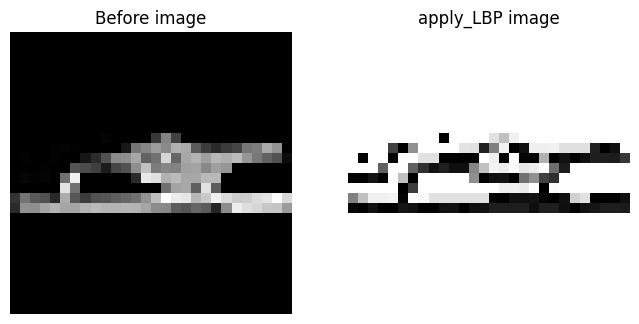

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(X_train[3454].reshape(28,28, 1), cmap=plt.cm.gray)
ax1.set_title('Before image')


ax2.axis('off')
ax2.imshow(X_train_LBP[3454].reshape(28,28, 1), cmap=plt.cm.gray)
ax2.set_title('apply_LBP image')
plt.show()

In [14]:
def apply_hog(images):
    result = []
    for image in images:
        hog_features = hog(image, orientations=6, pixels_per_cell=(3, 3),
                              cells_per_block=(2, 2), block_norm='L2')
        result.append(hog_features)
    return result

In [15]:
X_train_hog = apply_hog(X_train)
X_test_hog = apply_hog(X_test)

In [16]:
print("HOG 특성을 적용한 X_train의 형태: ", np.array(X_train_hog).shape)
print("HOG 특성을 적용한 X_test의 형태: ", np.array(X_test_hog).shape)

HOG 특성을 적용한 X_train의 형태:  (135312, 1536)
HOG 특성을 적용한 X_test의 형태:  (10000, 1536)


- 이미지 1개 HOG 특성 추출 해보기

1536


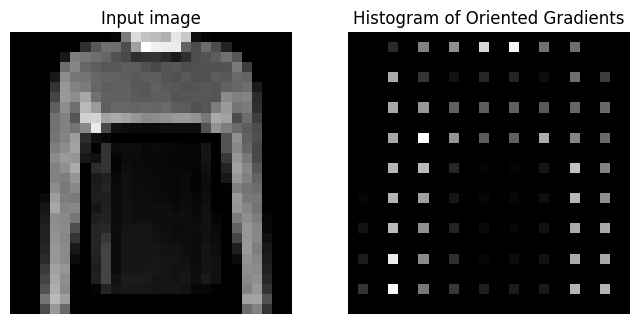

In [95]:
# 첫 번째 이미지의 HOG 특성 계산 및 시각화
image = X_train[21].reshape((28, 28))
hog_features, hog_image = hog(image, orientations=6, pixels_per_cell=(3, 3),
                              cells_per_block=(2, 2), visualize=True, block_norm='L2')
print(hog_features.shape[0])
# 원본 이미지와 HOG 특성 이미지를 출력
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')


ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [115]:
pca = PCA(n_components=466,random_state=45)
pca.fit(X_train_LBP)
X_train_pca = pca.transform(X_train_LBP)
X_test_pca = pca.transform(X_test_LBP)
X_train_PCA1 = pd.DataFrame(X_train_pca)
X_test_PCA1 = pd.DataFrame(X_test_pca)

ValueError: X has 784 features, but PCA is expecting 1536 features as input.

In [ ]:
print(X_train_pca.shape)

(135312, 466)


In [ ]:
optimal_c = 8
svc = SVC(gamma='scale',kernel='rbf',C=optimal_c ,random_state=45)

In [ ]:
svc.fit(X_train_PCA1,y_train)

SVC(C=8, random_state=45)

In [ ]:
file_name = "135312_lbp_c8"

In [ ]:
with open(f'../Preprocessing/models/{file_name}', 'wb') as f:
    pickle.dump(svc, f)

In [ ]:
with open('./models/135312_hog6_33_22_c21', 'rb') as f:
    svc = pickle.load(f)

In [ ]:
svc_pred = svc.predict(X_test_PCA1)

In [ ]:
print(svc_pred.shape)

(10000,)


In [ ]:
with open(f'../mAP/{file_name}.txt', 'w') as file:
    for i in range(svc_pred.shape[0]):
        file.write(f"{i:05d} {int(svc_pred[i])}\n")

In [ ]:
import sys
import numpy as np
from sklearn.metrics import auc
from collections import Counter

testResult_path = "../mAP/"+file_name+".txt"
label_path = "../mAP/label.txt"

# pred에 해당하는 testResult.txt 파일 읽어오는 부분입니다.
with open(testResult_path, 'r') as file1:
    preds = file1.readlines()

# 정답에 해당하는 label.txt 파일 읽어오는 부분입니다.
with open(label_path, 'r') as file2:
    labels = file2.readlines()
    

# pred와 label의 클래스값만 리스트로 변환하는 부분입니다.
p = np.array([pred.strip().split()[1] for pred in preds])
l = np.array([label.strip().split()[1] for label in labels])

# pred의 클래스 개수를 count하는 부분입니다.
predict_label_count_dict = Counter(p)
predict_label_count_dict = dict(sorted(predict_label_count_dict.items()))

## mAP 계산하는 부분입니다.
AP = []
num_class = 10

# 모든 클래스에 대해 반복
for c, freq in predict_label_count_dict.items() :
    TP = 0
    FN = 0

    temp_precision = []
    temp_recall = []
    
    for i in range(len(p)):
        # TP, FN 계산
        if l[i] == c and p[i] == c :
            TP += 1
        elif l[i] != c and p[i] == c :
            FN += 1
        
        # preciison, recall 계산            
        if TP+FN != 0: 
            temp_precision.append(TP/(TP+FN))
            temp_recall.append(TP/freq)

    # AP 배열에 클래스 각각의 AP value 저장
    # auc : preciison-recall curve의 면적 구해줌
    AP.append(auc(temp_recall, temp_precision))
    
mAP = sum(AP) / num_class

# 각각의 클래스에 대한 AP와 mAP의 Table 출력 부분입니다.
class_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
table = "| {:<13} | {:<13} |\n".format("Class", "AP") + "|---------------|---------------|\n"

for c_name, ap in zip(class_name, AP):
    table += "| {:<13} | {:<13.4f} |\n".format(c_name, ap)

table += "| {:<13} | {:<13.4f} |\n".format("mAP", mAP)

print(table)


| Class         | AP            |
|---------------|---------------|
| T-shirt/top   | 0.6646        |
| Trouser       | 0.9471        |
| Pullover      | 0.6535        |
| Dress         | 0.7494        |
| Coat          | 0.6045        |
| Sandal        | 0.9211        |
| Shirt         | 0.4607        |
| Sneaker       | 0.8400        |
| Bag           | 0.9168        |
| Ankle boot    | 0.8929        |
| mAP           | 0.7651        |

